<a href="https://colab.research.google.com/github/NoelBram/Projects/blob/master/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 30 not upgraded.
Need to get 420 MB of archives.
After this operation, 3,369 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 27s (15.6 MB/s)
(Reading database ... 155685 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155663 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt


In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-09-13 20:10:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.189.2, 2600:141b:e800:148c::317f, 2600:141b:e800:1488::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.220.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   173MB/s    in 4.7s    

2022-09-13 20:10:24 (168 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [ ]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  
  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  to_create = [
    '/tmp/cats-v-dogs',
    '/tmp/cats-v-dogs/training',
    '/tmp/cats-v-dogs/validation',
    '/tmp/cats-v-dogs/training/cats',
    '/tmp/cats-v-dogs/training/dogs',
    '/tmp/cats-v-dogs/validation/cats',
    '/tmp/cats-v-dogs/validation/dogs'
  ]

  for directory in to_create:
      try:
          os.mkdir(directory)
          print(directory, 'created')
      except:
          print(directory, 'failed')

  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

/tmp/cats-v-dogs created
/tmp/cats-v-dogs/training created
/tmp/cats-v-dogs/validation created
/tmp/cats-v-dogs/training/cats created
/tmp/cats-v-dogs/training/dogs created
/tmp/cats-v-dogs/validation/cats created
/tmp/cats-v-dogs/validation/dogs created


In [ ]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats


In [ ]:
# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  ### START CODE HERE
  all_files = []
    
  for file_name in os.listdir(SOURCE_DIR):
      file_path = SOURCE_DIR + file_name

      if os.path.getsize(file_path):
          all_files.append(file_name)
      else:
          print('{} is zero length, so ignoring'.format(file_name))
  
  n_files = len(all_files)
  split_point = int(n_files * SPLIT_SIZE)
  
  shuffled = random.sample(all_files, n_files)
  
  train_set = shuffled[:split_point]
  val_set = shuffled[split_point:]
  
  for file_name in train_set:
      copyfile(SOURCE_DIR + file_name, TRAINING_DIR + file_name)
      
  for file_name in val_set:
      copyfile(SOURCE_DIR + file_name, VALIDATION_DIR + file_name)

In [ ]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale=1 / 255)

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
  )

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale= 1/255)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
  )

  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(1,1), data_format=None, input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(152, 152, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.ZeroPadding2D(padding=(1,1), data_format=None, input_shape=(76, 76, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(78, 78, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.ZeroPadding2D(padding=(1,1), data_format=None, input_shape=(39, 39, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(41, 41, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

  ### END CODE HERE

  return model

In [ ]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/15
191/352 [===============>..............] - ETA: 4:56 - loss: 0.6604 - accuracy: 0.6381

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 679s 2s/step - loss: 0.6089 - accuracy: 0.6771 - val_loss: 0.5022 - val_accuracy: 0.7372
Epoch 2/15
352/352 [==============================] - 679s 2s/step - loss: 0.4783 - accuracy: 0.7712 - val_loss: 0.4712 - val_accuracy: 0.7764
Epoch 3/15
352/352 [==============================] - 728s 2s/step - loss: 0.4089 - accuracy: 0.8129 - val_loss: 0.4097 - val_accuracy: 0.8096
Epoch 4/15
352/352 [==============================] - 679s 2s/step - loss: 0.3497 - accuracy: 0.8445 - val_loss: 0.4256 - val_accuracy: 0.7984
Epoch 5/15
352/352 [==============================] - 653s 2s/step - loss: 0.2914 - accuracy: 0.8738 - val_loss: 0.4585 - val_accuracy: 0.8036
Epoch 6/15
352/352 [==============================] - 685s 2s/step - loss: 0.2269 - accuracy: 0.9066 - val_loss: 0.4527 - val_accuracy: 0.8052
Epoch 7/15
352/352 [==============================] - 732s 2s/step - loss: 0.1678 - accuracy: 0.9319 - val_loss: 0.5138 - val_accuracy: 0.8280
Epoch 8/15

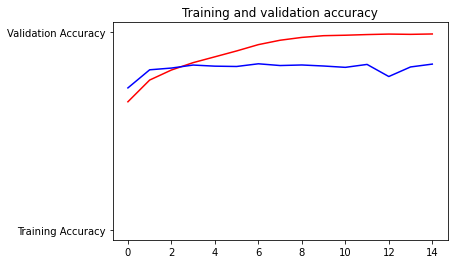

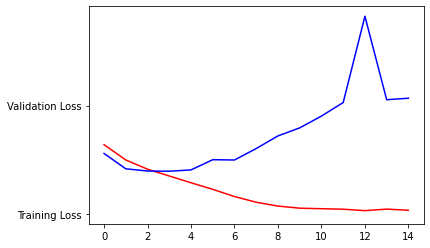

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()


In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()